# Import

In [287]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import inspect
import itertools
import pickle
import os
from scipy.ndimage.measurements import label

# Features

In [288]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [414]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        features.append(single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat))
    # Return list of feature vectors
    return features

# Classfier

In [415]:
# Divide up into cars and notcars
nongti_cars = glob.glob("vehicles/KITTI_extracted/*.png", recursive=True)
gti_cars = glob.glob("vehicles/GTI_*/*.png", recursive=True)
nongti_notcars = glob.glob("non-vehicles/Extras/*.png", recursive=True)
gti_notcars = glob.glob("non-vehicles/GTI/*.png", recursive=True)
cars = nongti_cars + gti_cars
notcars = nongti_notcars + gti_notcars
print(len(nongti_cars), len(gti_cars), len(nongti_notcars), len(gti_notcars), len(cars), len(notcars))

5966 2826 5068 3900 8792 8968


In [746]:
def train_classifier(color_space='RGB', orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0, spatial_size=(16,16),
                     hist_bins=16, spatial_feat=True, hist_feat=True,
                     hog_feat=True, save_pickle=False):
    frame = inspect.currentframe()
    args, _, _, values = inspect.getargvalues(frame)
    train_params = {i: values[i] for i in args}
    print(train_params)
    print()

    t=time.time()
    
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features[:len(nongti_cars)], 
                   notcar_features[:len(nongti_notcars)],
                   car_features[len(nongti_cars):], 
                   notcar_features[len(nongti_notcars):],)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(nongti_cars)), 
                   np.zeros(len(nongti_notcars)),
                   np.ones(len(gti_cars)),
                   np.zeros(len(gti_notcars))))

    nongit_len = len(nongti_cars)+len(nongti_notcars)
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X[:nongit_len], y[:nongit_len], test_size=0.25, random_state=rand_state)

    X_train = np.vstack((X_train, scaled_X[nongit_len:]))
    y_train = np.hstack((y_train[:], y[nongit_len:]))

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    if save_pickle:
        # Save the data for easy access
        pickle_file = 'classifier.pickle'
        if not os.path.isfile(pickle_file):
            print('Saving data to pickle file...')
            try:
                with open(pickle_file, 'wb') as pfile:
                    params = {
                            'svc': svc,
                            'scaler': X_scaler,
                            'orient': orient,
                            'pix_per_cell': pix_per_cell,
                            'cell_per_block': cell_per_block,
                            'spatial_size': spatial_size,
                            'hist_bins': hist_bins,
                            'hog_channel': hog_channel,
                            'spatial_feat': spatial_feat,
                            'hist_feat': hist_feat,
                            'hog_feat': hog_feat,
                    }
                    print(params)
                    pickle.dump(params, pfile, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', pickle_file, ':', e)
                raise
        print('Data cached in pickle file.')
    # Check the prediction time for a single sample
#     t=time.time()
#     n_predict = 10
#     print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
#     print('For these',n_predict, 'labels: ', y_test[0:n_predict])
#     t2 = time.time()
#     print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [747]:
### TODO: Tweak these parameters and see how the results change.
# for cs, o, ppc, cpb, hc, ss, hb, sf, hif, hof in itertools.product(
#     ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'], # Color space, Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#     [9], # HOG orientations
#     [8], # HOG pixels per cell
#     [2], # HOG cells per block
#     ['ALL'], # Hog channel, Can be 0, 1, 2, or "ALL"
#     [(16, 16)], # Spatial binning dimensions
#     [16], # Number of histogram bins
#     [True], # Spatial features on or off
#     [True], # Histogram features on or off
#     [True]): # HOG features on or off

#     if not sf and not hif and not hof:
#         continue
    
#     train_classifier(color_space=cs, orient=o, pix_per_cell=ppc,
#                      cell_per_block=cpb, hog_channel=hc, spatial_size=ss,
#                      hist_bins=hb, spatial_feat=sf, hist_feat=hif,
#                      hog_feat=hof)
#     print()

In [748]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

train_classifier(color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                 cell_per_block=cell_per_block, hog_channel=hog_channel, 
                 spatial_size=spatial_size, hist_bins=hist_bins, 
                 spatial_feat=spatial_feat, hist_feat=hist_feat,
                 hog_feat=hog_feat, save_pickle=True)

{'color_space': 'YCrCb', 'orient': 9, 'pix_per_cell': 8, 'cell_per_block': 2, 'hog_channel': 'ALL', 'spatial_size': (16, 16), 'hist_bins': 16, 'spatial_feat': True, 'hist_feat': True, 'hog_feat': True, 'save_pickle': True}

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
16.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9902
Saving data to pickle file...
{'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'orient': 9, 'pix_per_cell': 8, 'cell_per_block': 2, 'spatial_size': (16, 16), 'hist_bins': 16, 'hog_channel': 'ALL', 'spatial_feat': True, 'hist_feat': True, 'hog_feat': True}
Data cached in pickle file.


# Sliding Window

In [749]:
dist_pickle = pickle.load( open('classifier.pickle', "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

In [750]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    frame = inspect.currentframe()
    args, _, _, values = inspect.getargvalues(frame)
    params = {i: values[i] for i in args}
    del params['img']
    del params['windows']
    print(params)
    print()
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
#         plt.imshow(test_img)
#         plt.show()
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    print(len(on_windows), len(windows))
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    x_start_stop = (x_start_stop[0] or 0, x_start_stop[1] or img.shape[1])
    y_start_stop = (y_start_stop[0] or 0, y_start_stop[1] or img.shape[0])
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [ ]:
def get_window_image(image):
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=(None, None), 
                                y_start_stop=(390, 630), xy_window=(128, 128), 
                                xy_overlap=(0.85, 0.85))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                    

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img

for fname in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(fname)
    window_img = get_window_image(image)
    plt.imshow(window_img)
    plt.show()

In [ ]:
# image = mpimg.imread('/Users/qingdi/Desktop/test0.png')[:,:,:3]
# draw_image = np.copy(image)
# windows = slide_window(image, x_start_stop=(None, None), 
#                                 y_start_stop=(390, 640), xy_window=(64, 64), 
#                                 xy_overlap=(0.85, 0.85))

# hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                    
# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
# plt.imshow(window_img)
# plt.show()

# Hog Subsampling

In [752]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins):
#     frame = inspect.currentframe()
#     args, _, _, values = inspect.getargvalues(frame)
#     params = {i: values[i] for i in args}
#     del params['img']
#     print(params)
#     print()
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxlist = []
    
    for scale in scales:
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        if hog_channel == 'ALL':
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]
        else:
            ch1 = ctrans_tosearch[:,:,hog_channel]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        if hog_channel == 'ALL':
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        else:
            hog = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                if hog_channel == 'ALL':
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_feat = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                # Multi scale windows
                if (20 < win_draw <=70) and (xbox_left < 600 or xbox_left > 930 or ytop_draw+ystart > 420):
                    continue
                if (70 < win_draw <=96) and (xbox_left < 550 or ytop_draw+ystart > 440):
                    continue
                if (96 < win_draw <= 121) and (xbox_left < 500 or ytop_draw+ystart > 450):
                    continue
                if (122 < win_draw <= 148) and (xbox_left < 450):
                    continue
                
#                 print(xleft, xbox_left, ytop_draw, ystart, win_draw)
                
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    boxlist.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

#                 if scale == scales[0]:
#                     cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
#                 elif scale == scales[1]:
#                     cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6)
#                 elif scale == scales[2]:
#                     cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6)
#                 else:
#                     cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,255,0),6)

    return draw_img, boxlist

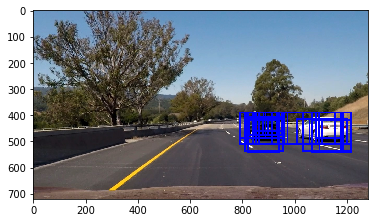

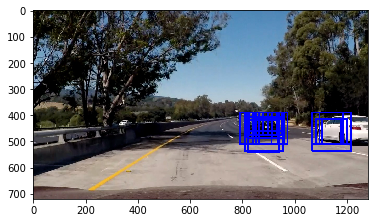

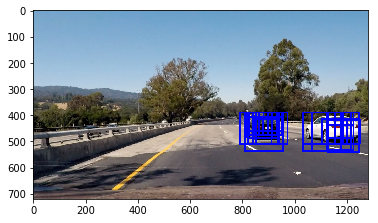

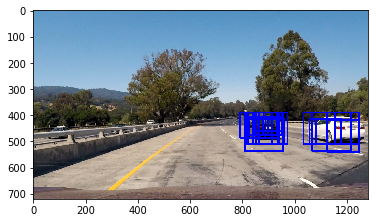

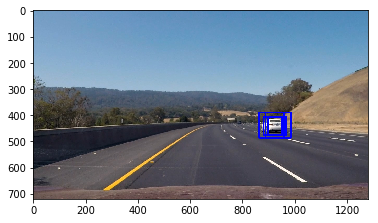

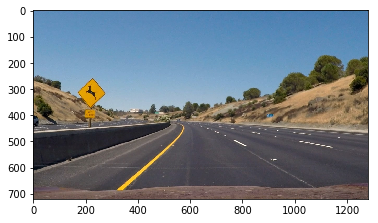

In [753]:
ystart = 390
ystop = 655
scales = [1.1, 1.5, 1.9, 2.3]

for fname in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(fname)
    out_img, boxlist = find_cars(image, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
#     print(sorted(boxlist))
    plt.imshow(out_img)
    plt.show()

# False Positive

In [756]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
#         print("car_number", car_number)
#         print("nonzero", nonzero)
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def filter_false_positive(image, box_list, threshold=2):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Smooth heat maps
    global heat_list
    heat_list.append(heat)
    if len(heat_list) >= 5:
        heat_list.pop(0)
    heat = np.mean(heat_list, axis=0)
#     plt.imshow(heat, cmap='hot')
#     plt.show()
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
#     plt.imshow(heatmap, cmap='hot')
#     plt.show()

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

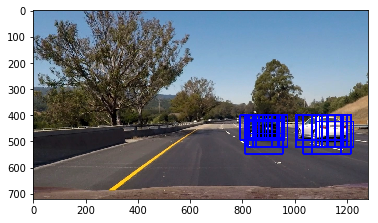

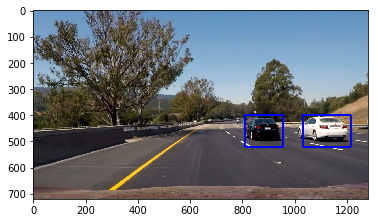

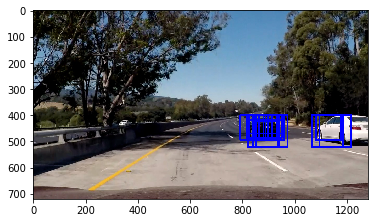

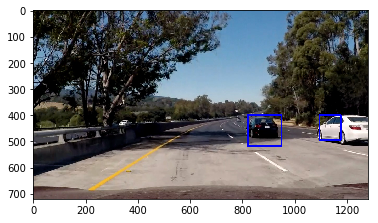

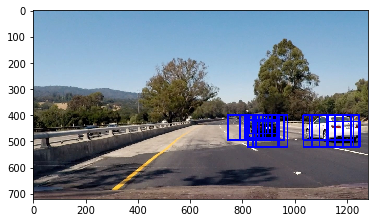

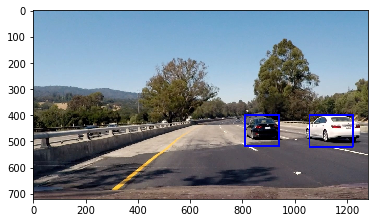

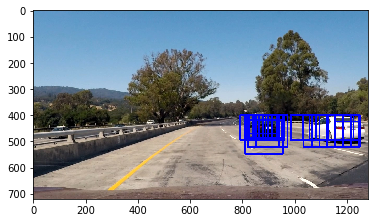

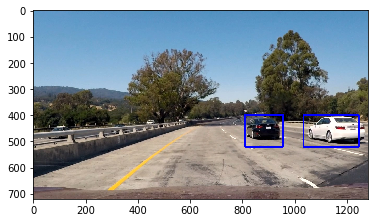

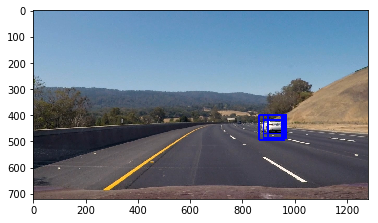

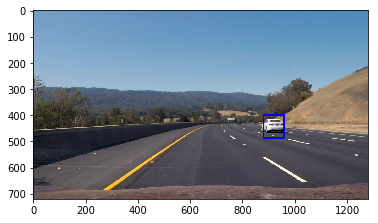

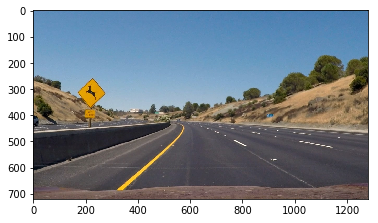

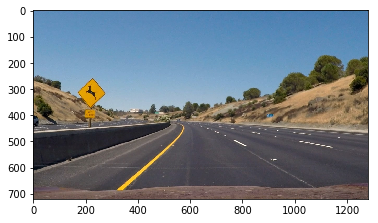

In [760]:
ystart = 390
ystop = 650
heat_threshold = 2
scales = [1.1, 1.5, 1.9, 2.3]
for fname in glob.glob('test_images/*.jpg'):
    heat_list = []
    image = mpimg.imread(fname)
    out_img, box_list = find_cars(image, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    plt.imshow(out_img)
    plt.show()
#     print(sorted(box_list))
    draw_image = filter_false_positive(image, box_list, threshold=heat_threshold)
    plt.imshow(draw_image)
    plt.show()

# Video

In [761]:
heat_list = []
def process_image(image):
    _, box_list = find_cars(image, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    draw_image = filter_false_positive(image, box_list)
    return draw_image


from moviepy.editor import VideoFileClip
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
new_clip = clip.fl_image(process_image)
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [14:11<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 13min 29s, sys: 1min 8s, total: 14min 37s
Wall time: 14min 11s
